In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
np.set_printoptions(precision=2, suppress=True)

In [4]:
import tensorflow as tf
import os

BATCH_SIZE = 128

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "series/18-03-24-020248/var7/models/activepolicy-18-03-24-020450/model-6400000.meta" # ok results, no error > 80% usually, usually better than mostcommon
META_FILE = "series/18-03-26-122044/var8-lstm1/models/activepolicy-18-03-26-122222/model-16000000.meta"  # usually slightly worse than mostcommon

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from series/18-03-26-122044/var8-lstm1/models/activepolicy-18-03-26-122222/model-16000000


In [5]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [6]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * BATCH_SIZE, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

1.0 [1.    0.953 1.    1.    1.    0.999 1.    1.    0.    0.    0.    0.
 0.    0.    0.    0.   ]


In [9]:
# Because we have to pass full batch

logfile = open("/tmp/log", "w")

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] * BATCH_SIZE
        cnfs_clauses = [[claus + tuple([claus[0]] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', cnfs_clauses[0], end=' ', file=logfile)
        print("probs:",  policy_probs[0], end=' \n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

#Sats: 400; avg step: 3.71; stdev step: 1.14; avg error: 0.63; stdev error: 0.66


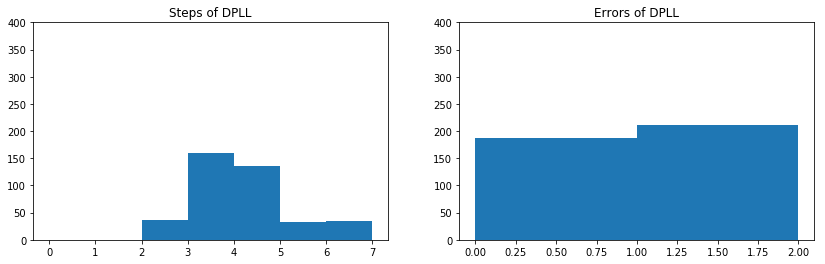

#Sats: 400; avg step: 3.69; stdev step: 1.18; avg error: 0.62; stdev error: 0.65


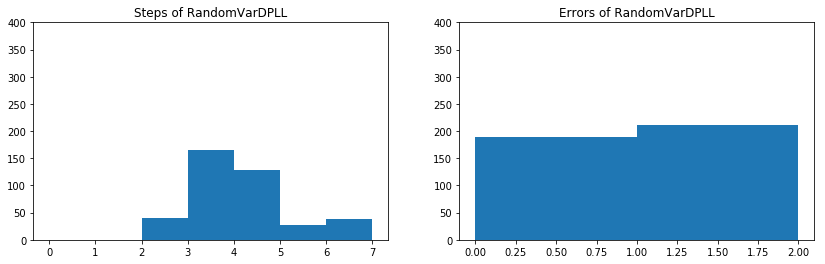

#Sats: 400; avg step: 3.02; stdev step: 0.76; avg error: 0.14; stdev error: 0.36


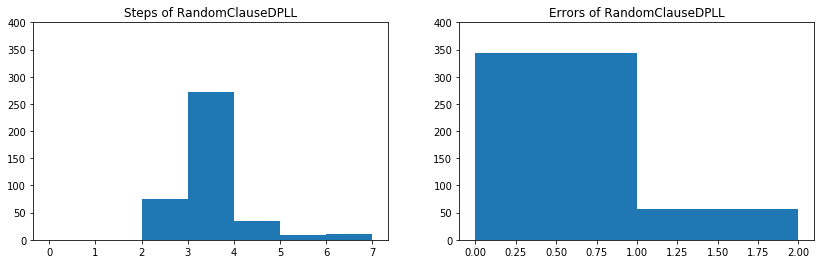

#Sats: 400; avg step: 2.85; stdev step: 0.55; avg error: 0.01; stdev error: 0.12


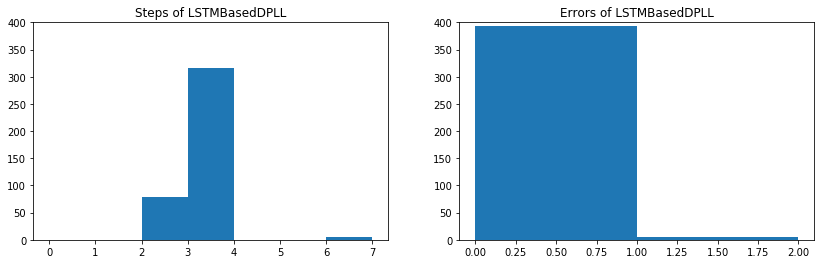

#Sats: 400; avg step: 2.67; stdev step: 0.47; avg error: 0.00; stdev error: 0.05


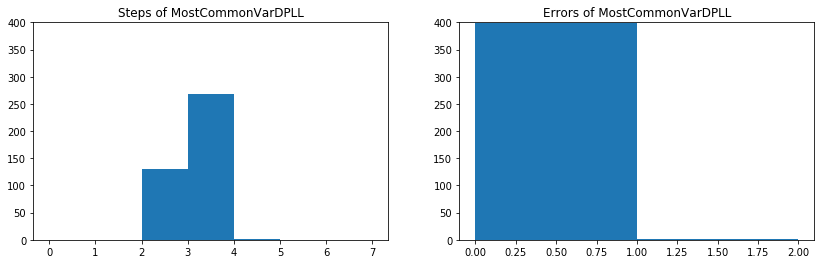

In [13]:
print_all(400, 2, 2, 3)

#Sats: 100; avg step: 8.40; stdev step: 2.58; avg error: 1.97; stdev error: 0.99


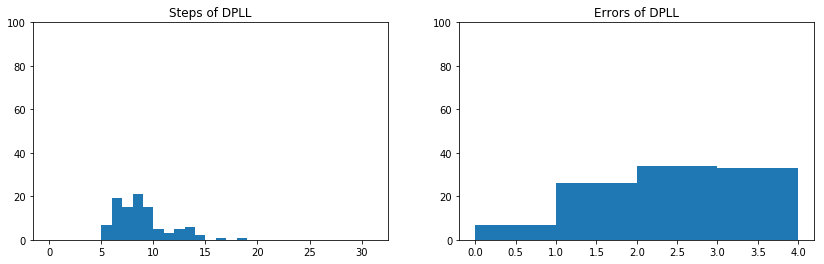

#Sats: 100; avg step: 9.14; stdev step: 2.91; avg error: 2.04; stdev error: 0.96


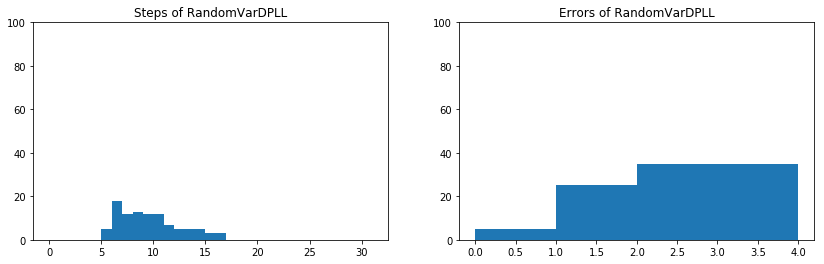

#Sats: 100; avg step: 6.38; stdev step: 1.86; avg error: 0.79; stdev error: 0.73


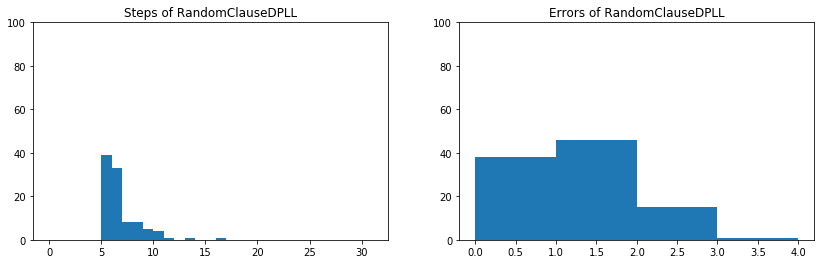

#Sats: 100; avg step: 5.45; stdev step: 1.80; avg error: 0.07; stdev error: 0.26


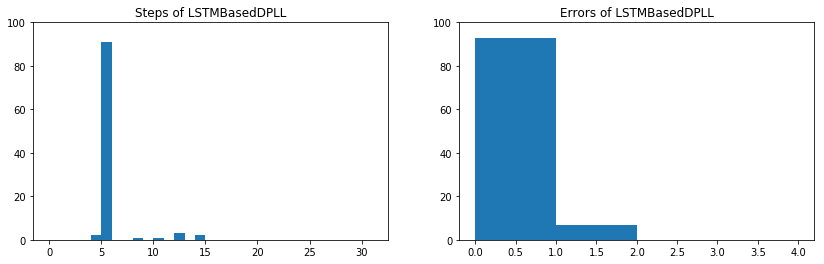

#Sats: 100; avg step: 5.04; stdev step: 0.53; avg error: 0.02; stdev error: 0.14


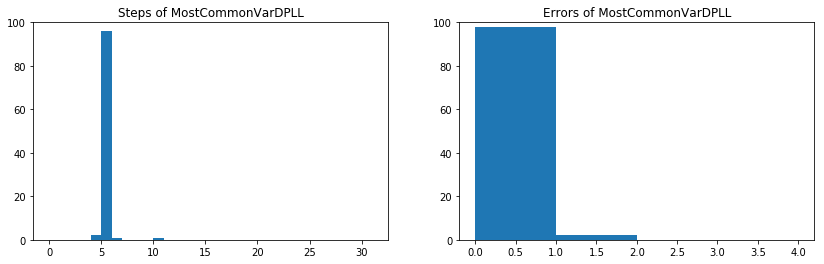

In [14]:
print_all(100, 2, 4, 20)

#Sats: 100; avg step: 7.23; stdev step: 3.34; avg error: 1.09; stdev error: 0.94


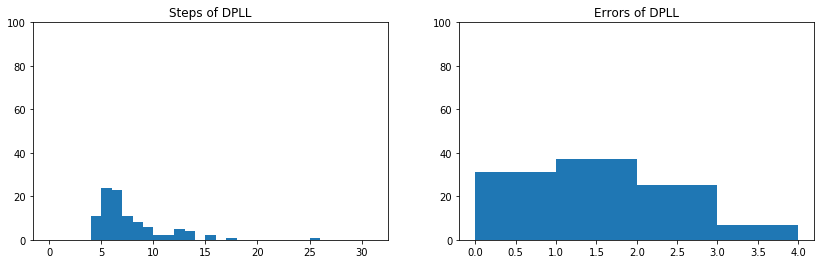

#Sats: 100; avg step: 7.66; stdev step: 3.71; avg error: 1.11; stdev error: 0.84


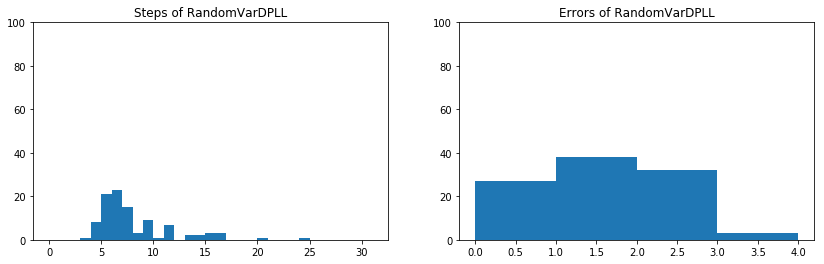

#Sats: 100; avg step: 6.16; stdev step: 3.02; avg error: 0.47; stdev error: 0.66


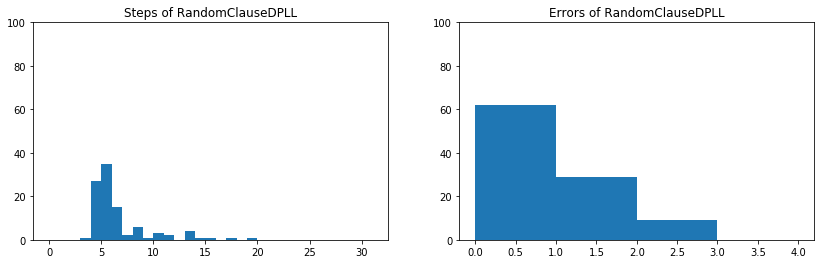

#Sats: 100; avg step: 5.39; stdev step: 3.25; avg error: 0.08; stdev error: 0.34


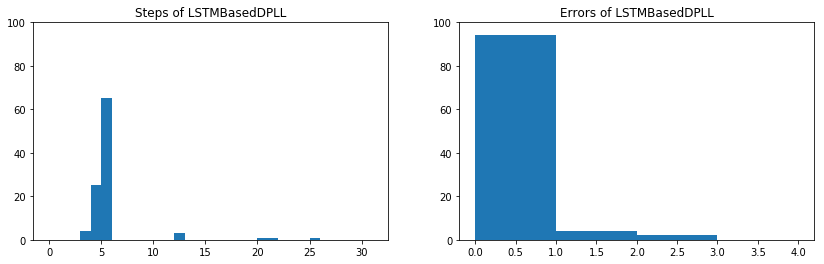

#Sats: 100; avg step: 4.51; stdev step: 1.37; avg error: 0.14; stdev error: 0.40


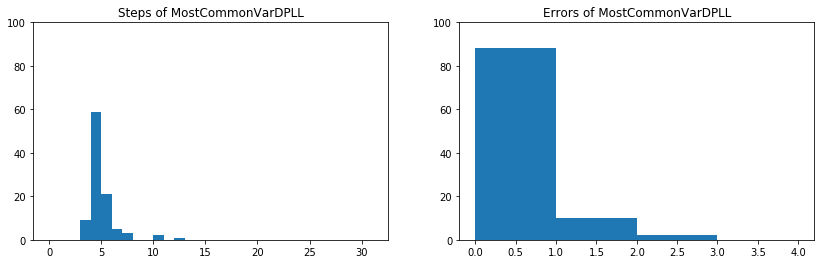

In [15]:
print_all(100, 3, 4, 10)

#Sats: 100; avg step: 10.28; stdev step: 4.81; avg error: 1.70; stdev error: 0.98


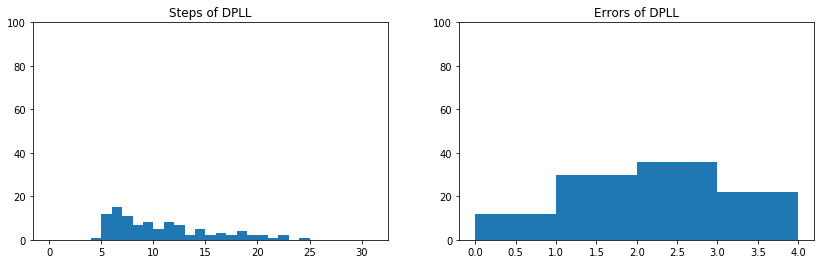

#Sats: 100; avg step: 10.26; stdev step: 4.69; avg error: 1.70; stdev error: 0.99


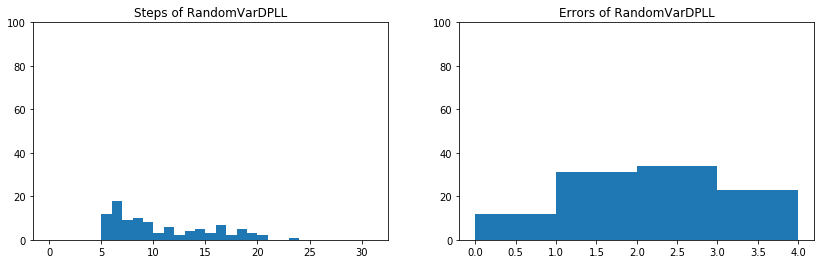

#Sats: 100; avg step: 8.76; stdev step: 4.46; avg error: 0.97; stdev error: 0.87


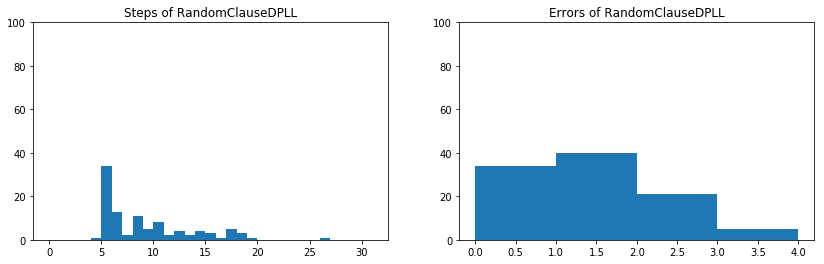

#Sats: 100; avg step: 5.90; stdev step: 2.91; avg error: 0.11; stdev error: 0.31


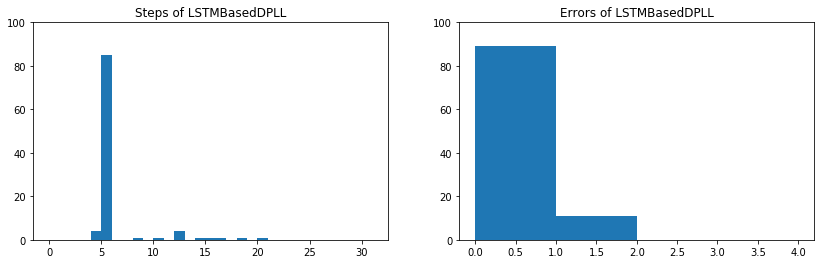

#Sats: 100; avg step: 6.11; stdev step: 2.53; avg error: 0.35; stdev error: 0.52


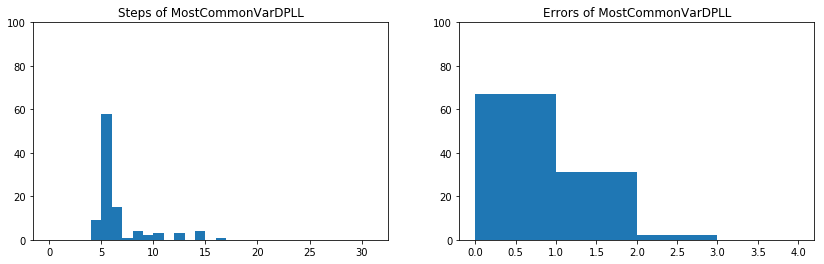

In [16]:
print_all(100, 3, 4, 20)

#Sats: 100; avg step: 10.11; stdev step: 3.78; avg error: 2.01; stdev error: 0.97


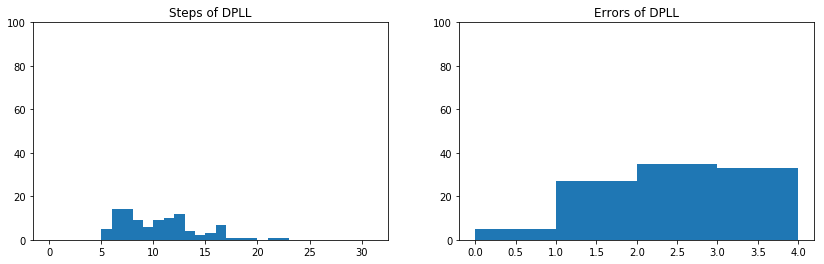

#Sats: 100; avg step: 10.29; stdev step: 4.04; avg error: 2.03; stdev error: 0.95


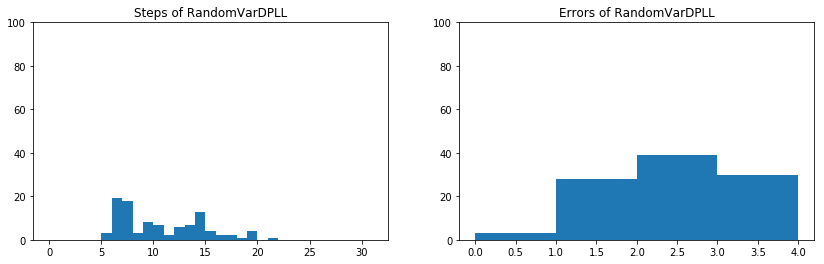

#Sats: 100; avg step: 9.16; stdev step: 3.55; avg error: 1.37; stdev error: 0.92


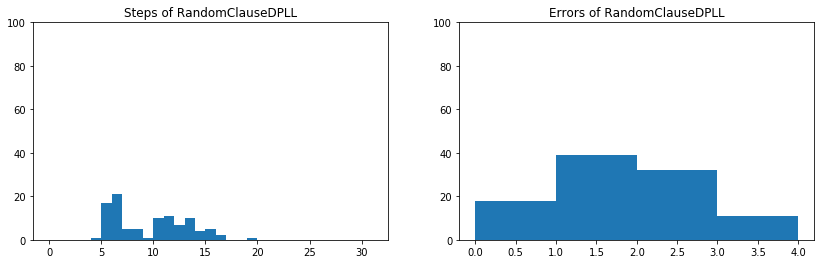

#Sats: 100; avg step: 5.56; stdev step: 1.80; avg error: 0.11; stdev error: 0.31


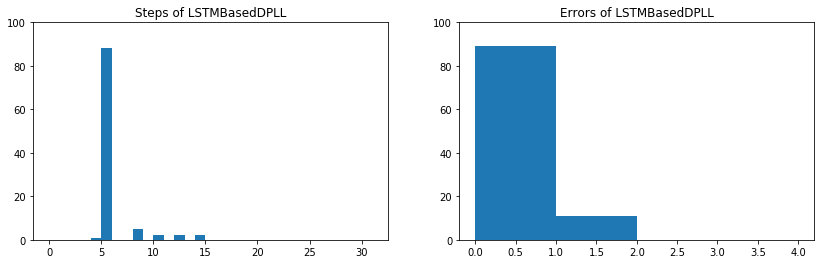

#Sats: 100; avg step: 5.93; stdev step: 2.08; avg error: 0.26; stdev error: 0.46


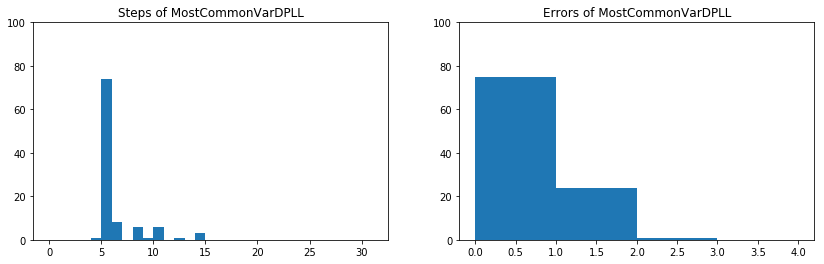

In [17]:
print_all(100, 3, 4, 40)

#Sats: 100; avg step: 15.21; stdev step: 7.06; avg error: 2.43; stdev error: 1.11


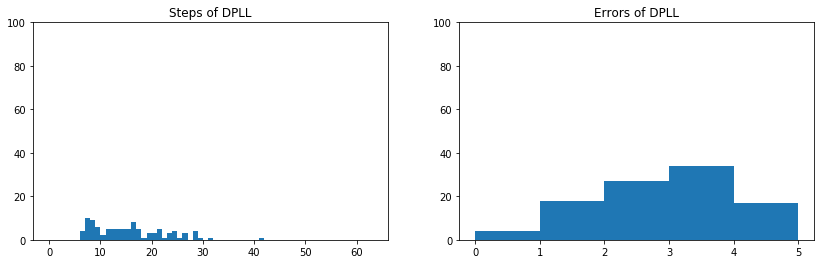

#Sats: 100; avg step: 15.02; stdev step: 7.05; avg error: 2.29; stdev error: 1.11


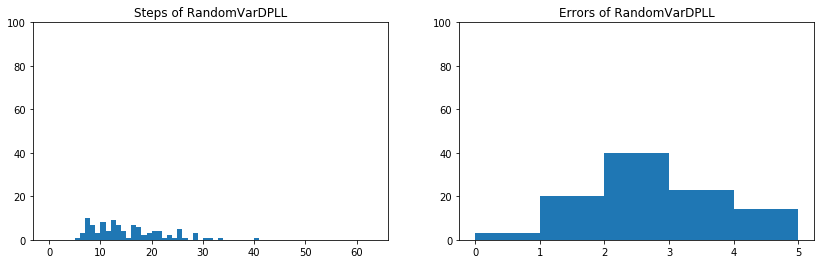

#Sats: 100; avg step: 11.65; stdev step: 5.56; avg error: 1.38; stdev error: 0.99


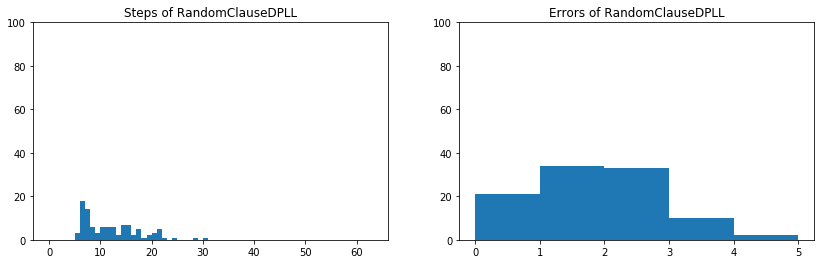

#Sats: 100; avg step: 9.10; stdev step: 6.57; avg error: 0.25; stdev error: 0.48


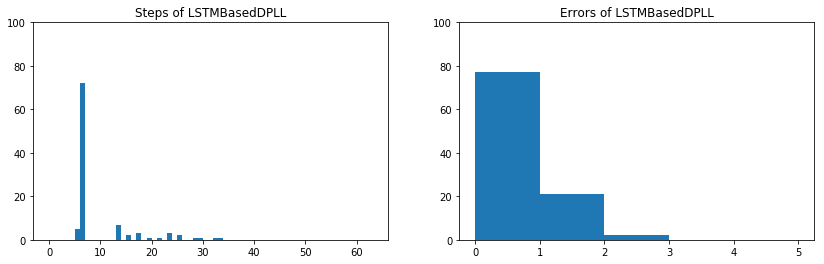

#Sats: 100; avg step: 7.81; stdev step: 3.67; avg error: 0.42; stdev error: 0.57


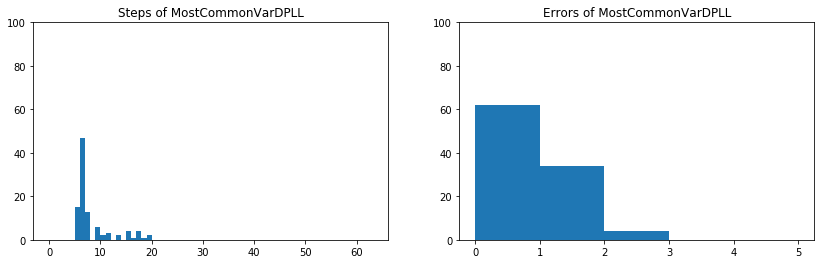

In [18]:
print_all(100, 3, 5, 30)

#Sats: 100; avg step: 14.73; stdev step: 6.39; avg error: 2.26; stdev error: 0.99


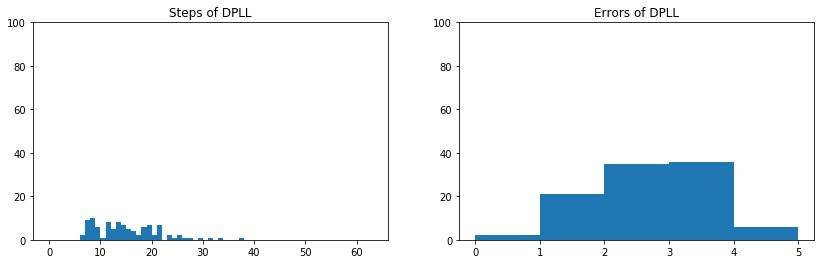

#Sats: 100; avg step: 14.58; stdev step: 6.80; avg error: 2.47; stdev error: 1.18


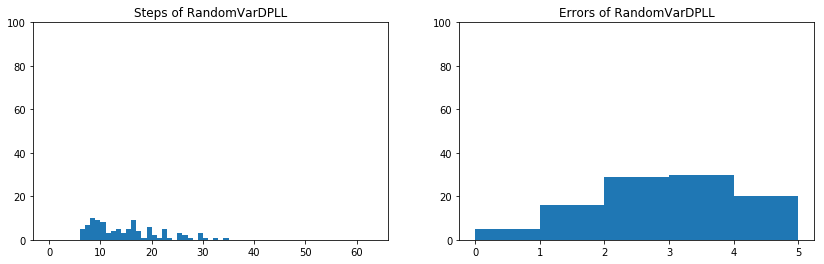

#Sats: 100; avg step: 13.03; stdev step: 6.03; avg error: 1.54; stdev error: 0.99


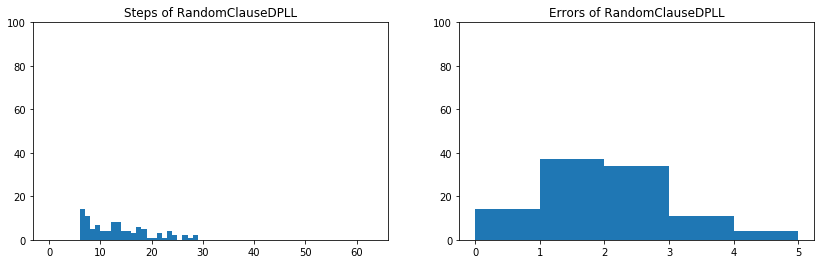

#Sats: 100; avg step: 7.74; stdev step: 4.22; avg error: 0.20; stdev error: 0.42


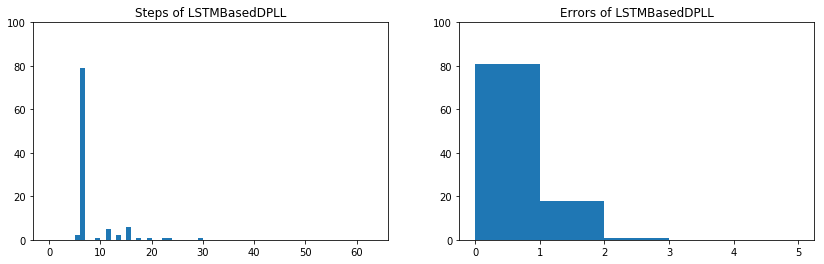

#Sats: 100; avg step: 7.95; stdev step: 3.87; avg error: 0.37; stdev error: 0.54


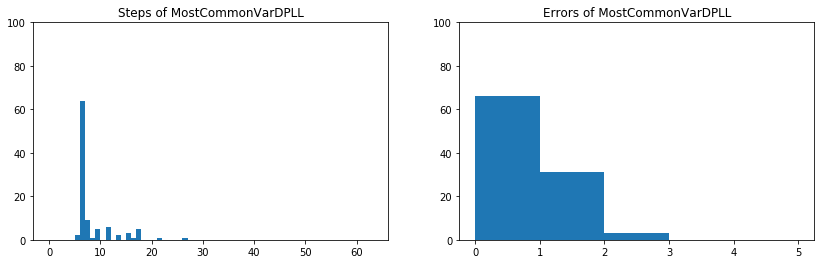

In [19]:
print_all(100, 3, 5, 40)

#Sats: 100; avg step: 22.51; stdev step: 10.92; avg error: 2.85; stdev error: 1.20


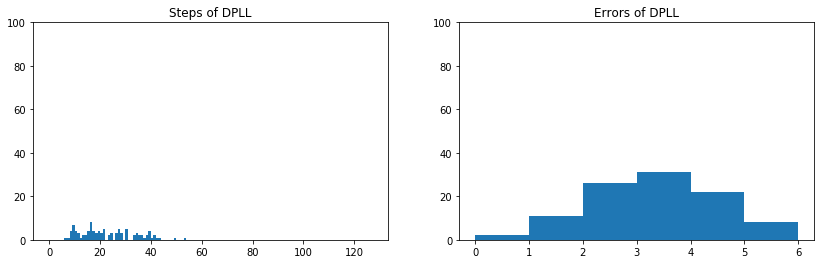

#Sats: 100; avg step: 22.71; stdev step: 11.11; avg error: 2.88; stdev error: 1.20


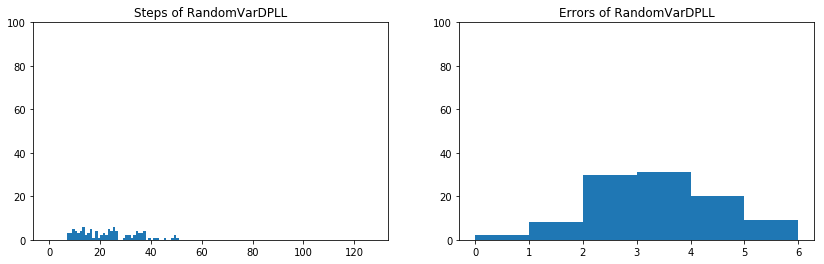

#Sats: 100; avg step: 17.55; stdev step: 9.50; avg error: 1.82; stdev error: 1.02


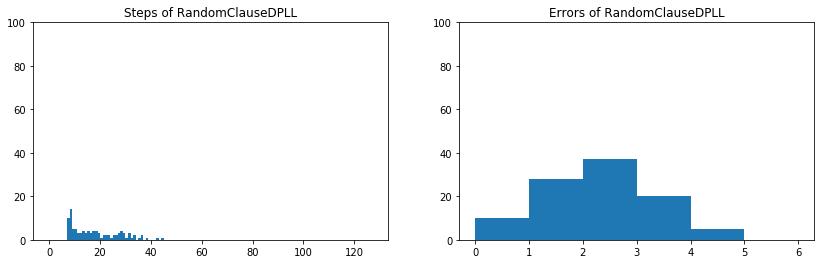

#Sats: 100; avg step: 13.25; stdev step: 10.21; avg error: 0.36; stdev error: 0.52


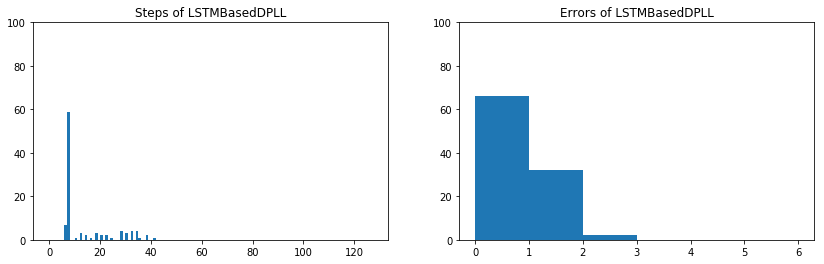

#Sats: 100; avg step: 10.43; stdev step: 6.05; avg error: 0.50; stdev error: 0.61


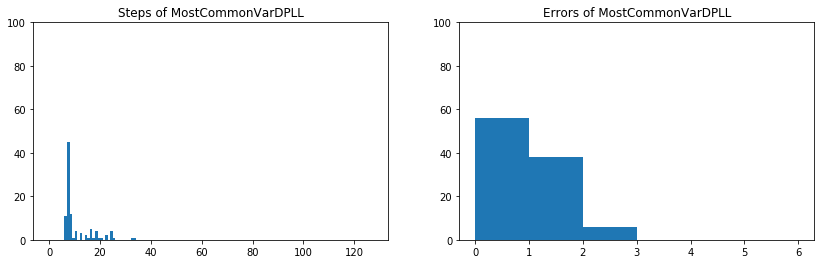

In [20]:
print_all(100, 3, 6, 40)

#Sats: 100; avg step: 17.07; stdev step: 6.60; avg error: 3.03; stdev error: 1.13


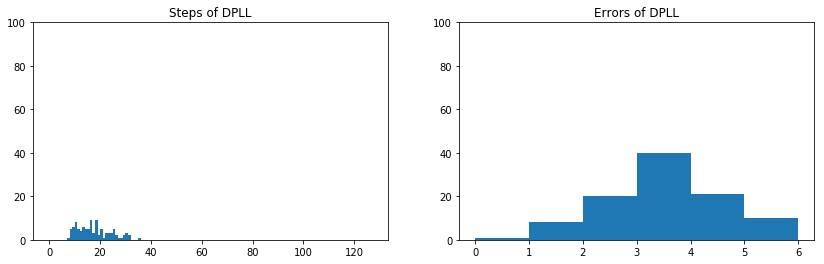

#Sats: 100; avg step: 17.70; stdev step: 6.76; avg error: 3.19; stdev error: 1.29


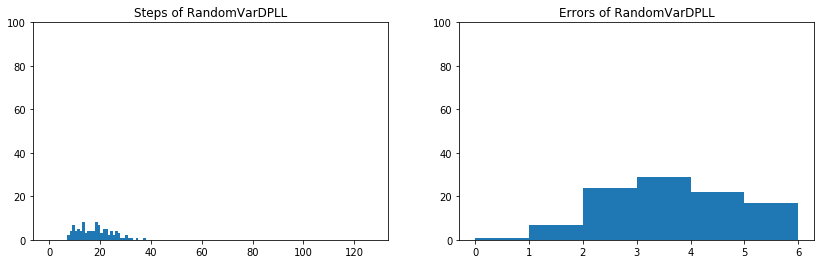

#Sats: 100; avg step: 13.88; stdev step: 6.29; avg error: 1.82; stdev error: 1.11


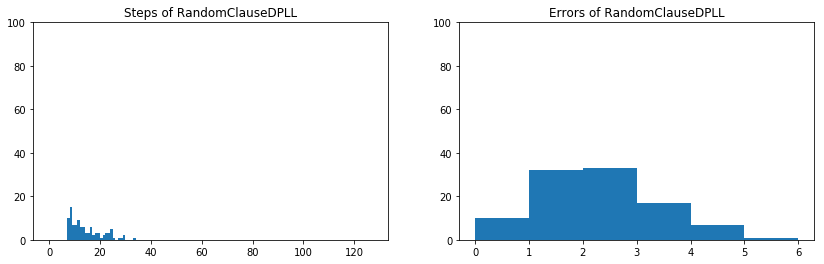

#Sats: 100; avg step: 8.08; stdev step: 3.15; avg error: 0.14; stdev error: 0.37


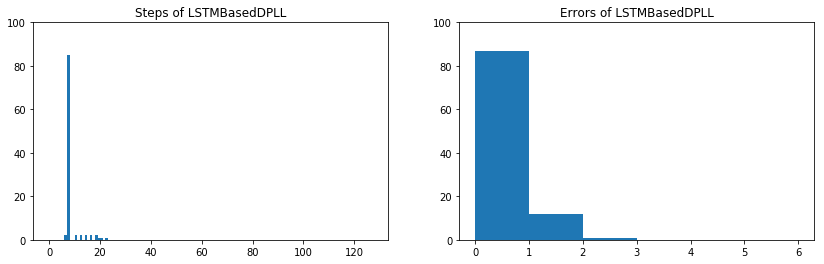

#Sats: 100; avg step: 8.06; stdev step: 2.57; avg error: 0.28; stdev error: 0.51


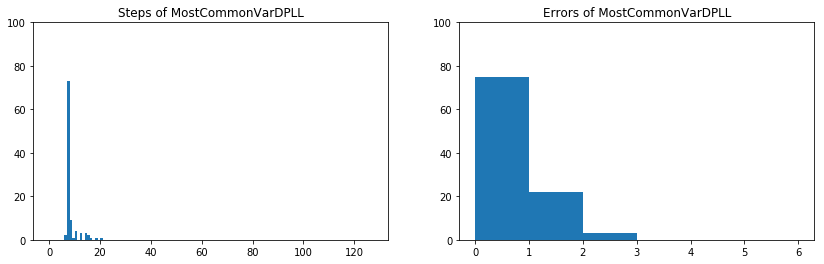

In [21]:
print_all(100, 3, 6, 70)

#Sats: 100; avg step: 20.33; stdev step: 15.20; avg error: 2.26; stdev error: 1.17


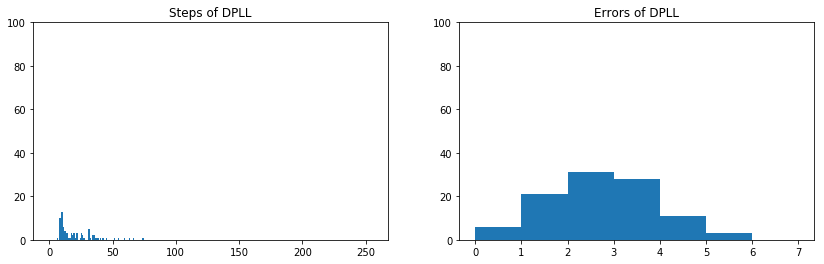

#Sats: 100; avg step: 18.68; stdev step: 14.03; avg error: 2.08; stdev error: 1.13


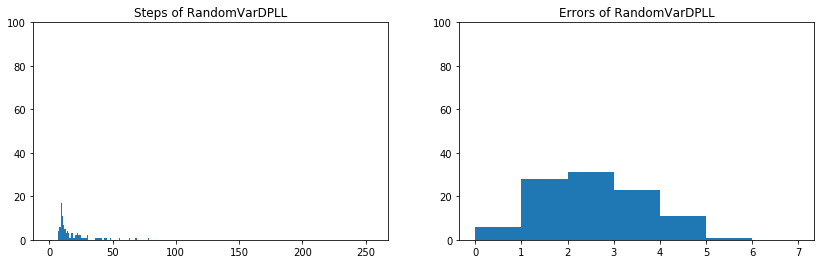

#Sats: 100; avg step: 14.39; stdev step: 10.47; avg error: 0.93; stdev error: 0.83


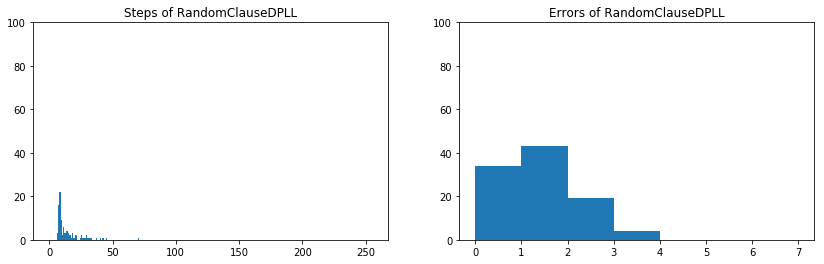

#Sats: 100; avg step: 12.33; stdev step: 17.19; avg error: 0.15; stdev error: 0.43


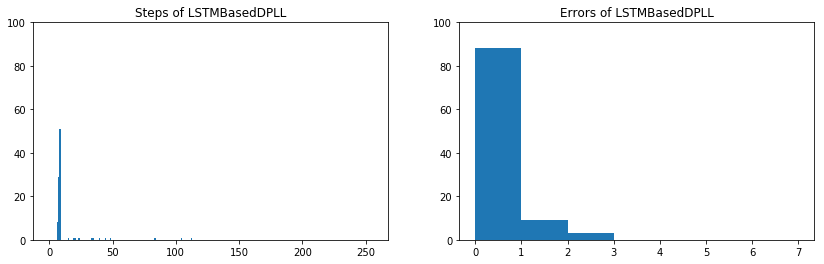

#Sats: 100; avg step: 9.00; stdev step: 6.35; avg error: 0.37; stdev error: 0.58


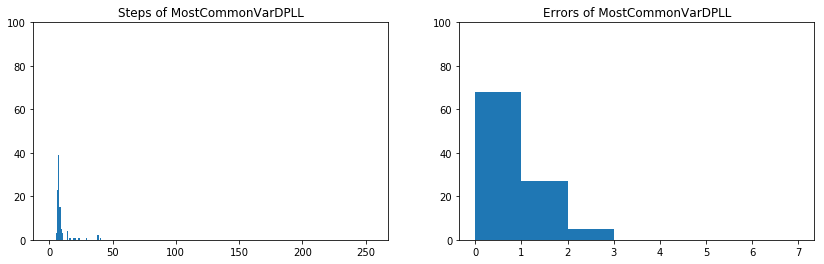

In [22]:
print_all(100, 3, 7, 20)

#Sats: 100; avg step: 24.18; stdev step: 11.83; avg error: 3.52; stdev error: 1.36


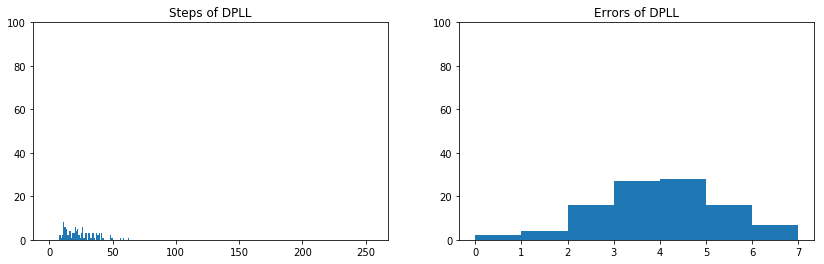

#Sats: 100; avg step: 22.64; stdev step: 10.31; avg error: 3.44; stdev error: 1.33


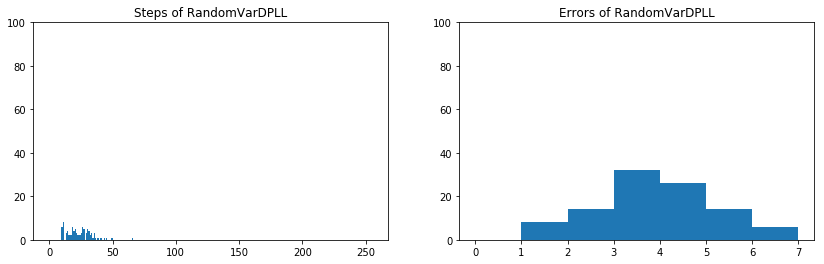

#Sats: 100; avg step: 18.91; stdev step: 9.10; avg error: 2.27; stdev error: 1.23


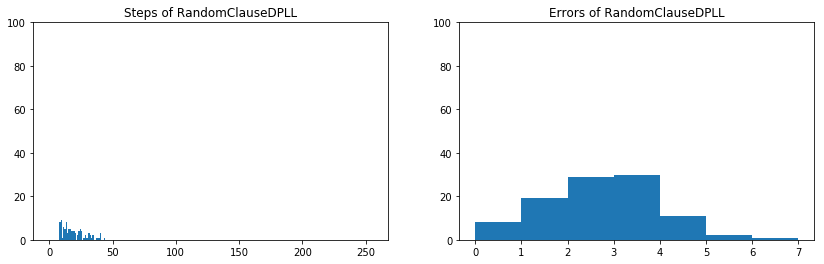

#Sats: 100; avg step: 10.99; stdev step: 7.20; avg error: 0.24; stdev error: 0.47


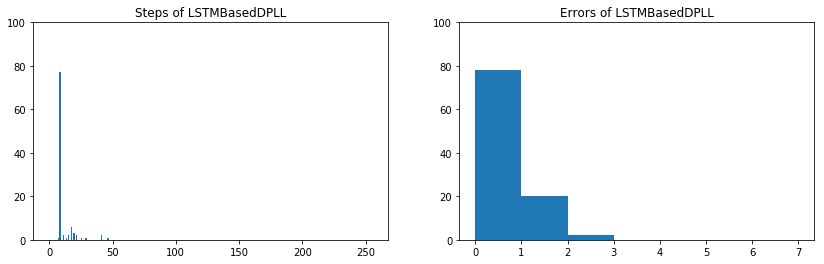

#Sats: 100; avg step: 11.14; stdev step: 5.29; avg error: 0.41; stdev error: 0.57


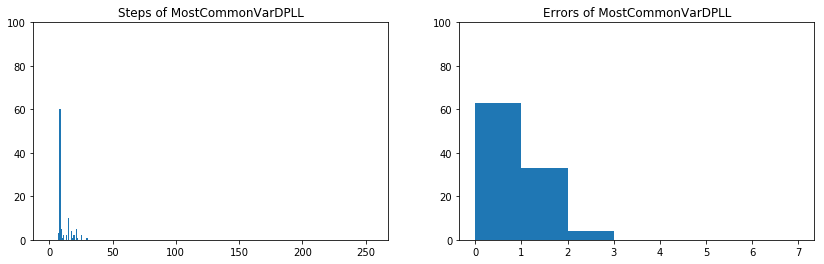

In [23]:
print_all(100, 3, 7, 70)

#Sats: 100; avg step: 38.79; stdev step: 24.49; avg error: 3.52; stdev error: 1.34


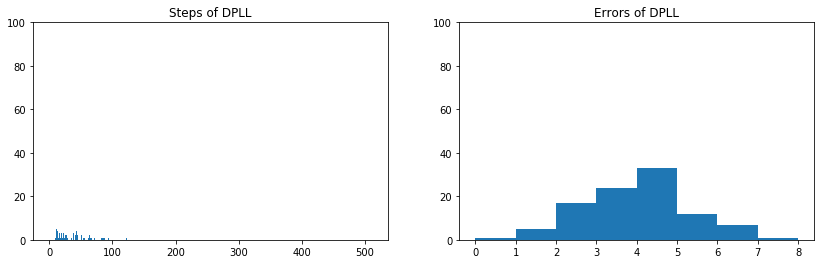

#Sats: 100; avg step: 41.09; stdev step: 27.01; avg error: 3.41; stdev error: 1.42


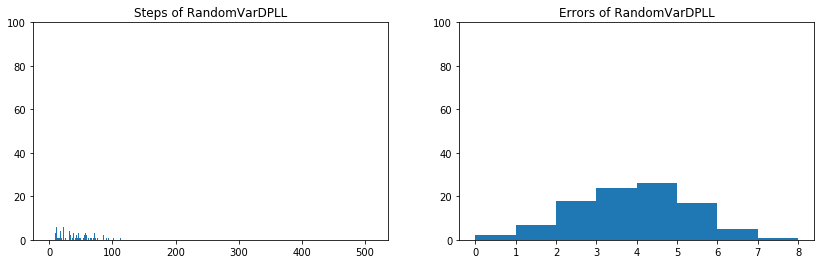

#Sats: 100; avg step: 33.41; stdev step: 21.81; avg error: 2.18; stdev error: 1.25


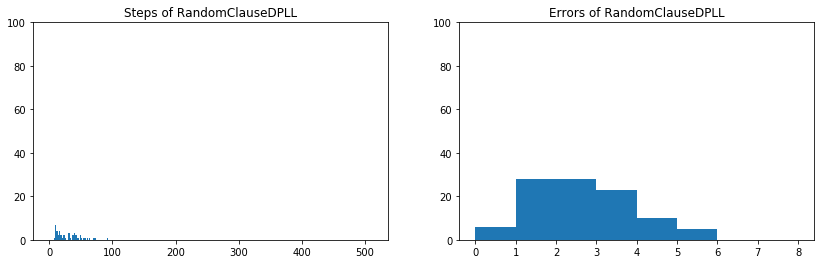

#Sats: 100; avg step: 16.38; stdev step: 17.22; avg error: 0.31; stdev error: 0.61


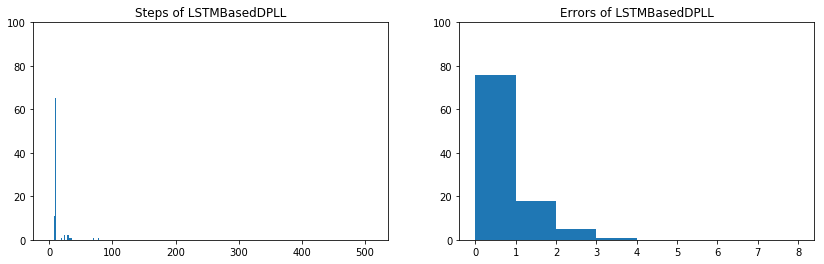

#Sats: 100; avg step: 14.81; stdev step: 11.45; avg error: 0.68; stdev error: 0.76


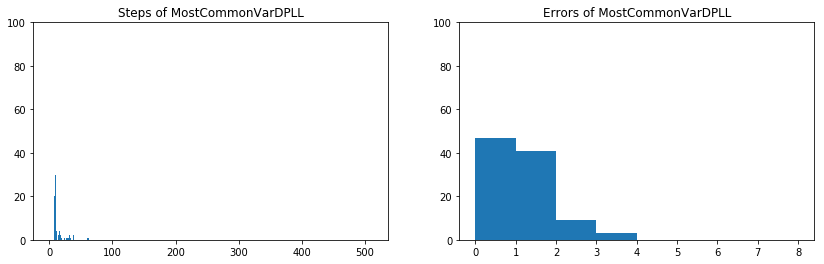

In [24]:
print_all(100, 3, 8, 40)

#Sats: 100; avg step: 40.03; stdev step: 24.73; avg error: 3.62; stdev error: 1.47


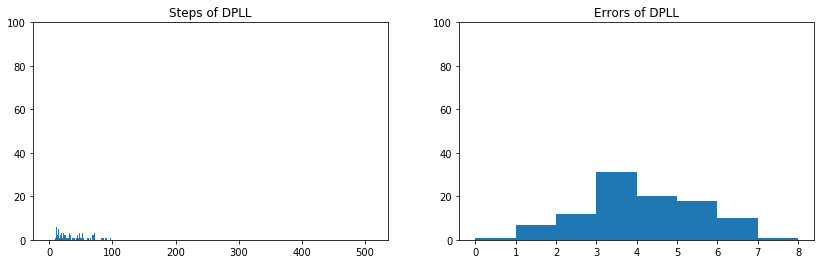

#Sats: 100; avg step: 39.25; stdev step: 19.39; avg error: 3.68; stdev error: 1.46


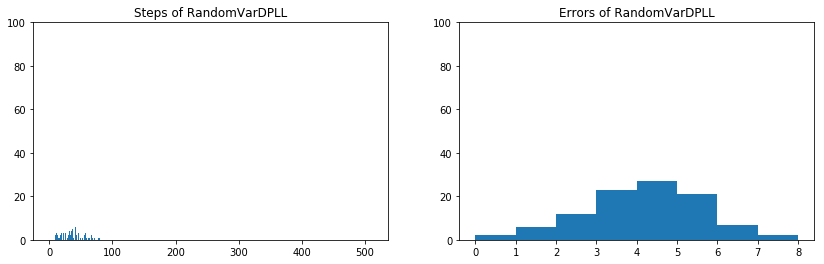

#Sats: 100; avg step: 27.37; stdev step: 15.79; avg error: 2.05; stdev error: 1.17


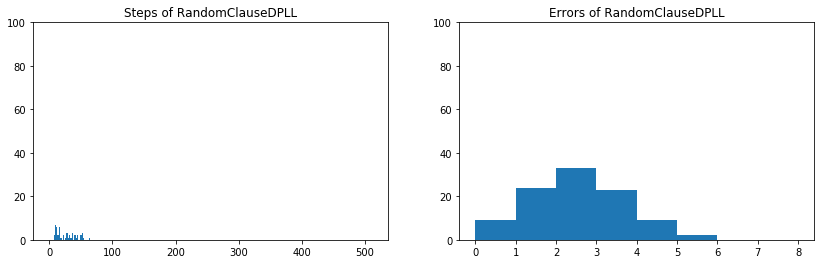

#Sats: 100; avg step: 19.73; stdev step: 19.94; avg error: 0.36; stdev error: 0.54


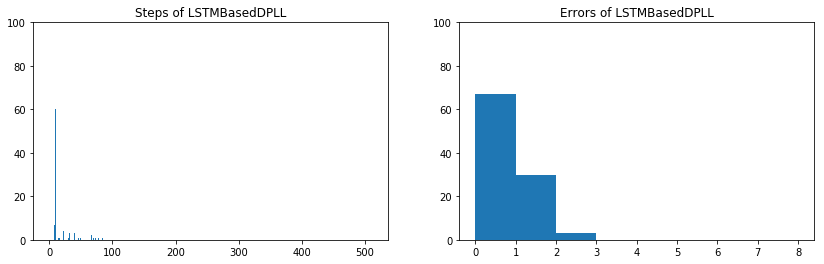

#Sats: 100; avg step: 15.27; stdev step: 11.05; avg error: 0.66; stdev error: 0.78


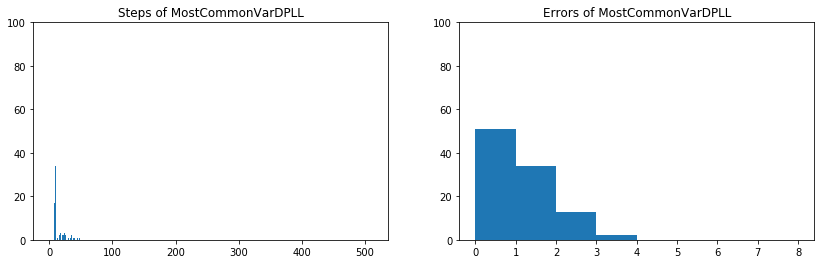

In [25]:
print_all(100, 3, 8, 50)